In [ ]:
!pip install tensorflow

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# **Combine Lag**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/combined_lagEDA.csv')
X = df.drop(columns=['Stress'])
y = df['Stress']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
window_size = 10
n_features = X_scaled.shape[1]

In [ ]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size), :])
        ys.append(y.iloc[i + window_size])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, window_size)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

In [ ]:
num_classes = len(np.unique(y_train))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(window_size, n_features), return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        28,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,499 (166.01 KB)

 Trainable params: 42,499 (166.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/50
249/249 - 11s - 43ms/step - accuracy: 0.6297 - loss: 0.8342 - val_accuracy: 0.6613 - val_loss: 0.7393
Epoch 2/50
249/249 - 3s - 14ms/step - accuracy: 0.6949 - loss: 0.6952 - val_accuracy: 0.6879 - val_loss: 0.6814
Epoch 3/50
249/249 - 5s - 20ms/step - accuracy: 0.7362 - loss: 0.6273 - val_accuracy: 0.7332 - val_loss: 0.6156
Epoch 4/50
249/249 - 6s - 25ms/step - accuracy: 0.7645 - loss: 0.5739 - val_accuracy: 0.7432 - val_loss: 0.5541
Epoch 5/50
249/249 - 4s - 17ms/step - accuracy: 0.7896 - loss: 0.5108 - val_accuracy: 0.7834 - val_loss: 0.4907
Epoch 6/50
249/249 - 4s - 14ms/step - accuracy: 0.8091 - loss: 0.4697 - val_accuracy: 0.8045 - val_loss: 0.4614
Epoch 7/50
249/249 - 5s - 20ms/step - accuracy: 0.8272 - loss: 0.4230 - val_accuracy: 0.8312 - val_loss: 0.3950
Epoch 8/50
249/249 - 4s - 14ms/step - accuracy: 0.8423 - loss: 0.3934 - val_accuracy: 0.8372 - val_loss: 0.3856
Epoch 9/50
249/249 - 5s - 21ms/step - accuracy: 0.8575 - loss: 0.3536 - val_accuracy: 0.8497 - val_loss

In [ ]:
y_pred_prob = model.predict(X_test)
if num_classes > 2:
    y_pred = np.argmax(y_pred_prob, axis=1)
else:
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1080
         1.0       0.92      0.84      0.88       450
         2.0       0.94      0.95      0.95       957

    accuracy                           0.95      2487
   macro avg       0.94      0.93      0.93      2487
weighted avg       0.95      0.95      0.95      2487



In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix:


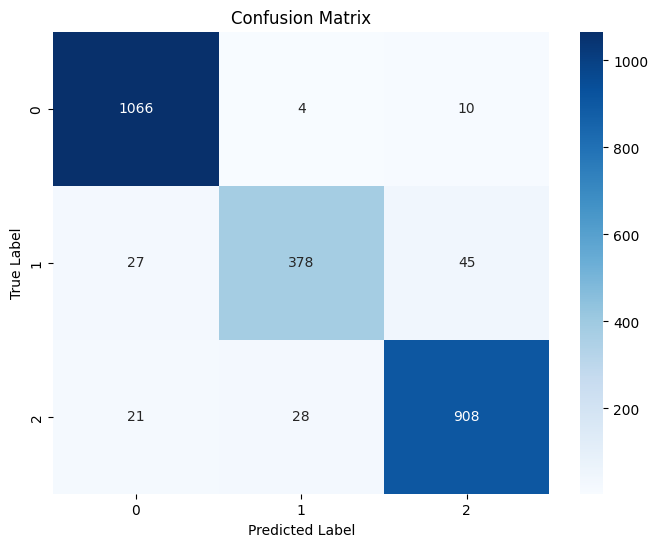

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

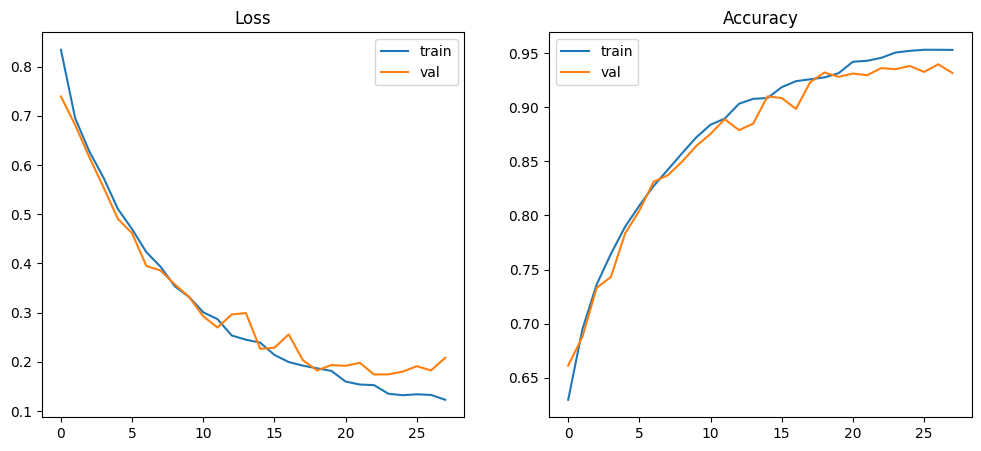

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

In [ ]:
model.save('lstm_stress_dryad_model.h5')
import joblib
joblib.dump(scaler, 'scaler.save')

['scaler.save']